In [1]:
%load_ext autoreload
%autoreload 2

In [42]:
import pandas as pd
from definitions import RESULTS_DIR, FIGURES_DIR
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [119]:
# Nicer log names
mapping = {
    'BPI_Challenge_2013_closed_problems.xes.gz': 'BPI13 Closed',
    'BPI_Challenge_2012.xes.gz': 'BPI12',
    'BPI_Challenge_2013_incidents.xes.gz': 'BPI13 Incidents',
    'BPI_Challenge_2013_open_problems.xes.gz': 'BPI13 Open',
    'BPI%20Challenge%202017.xes.gz': 'BPI17',
    'BPIC15_1.xes': 'BPI15',
    'Road_Traffic_Fine_Management_Process.xes.gz': 'RTFMP',
    'Sepsis%20Cases%20-%20Event%20Log.xes.gz': 'Sepsis',
    'helpdesk.csv': 'Helpdesk',
    'RTFMP_filtered.xes': 'RTFMP filtered',
}
# Nicer freezed layers
freezed_layers_mapping = lambda x: re.sub(r"[^\d, ]", "", x) if isinstance(x, str) else 'None'
# Nicer architecture names
architecture_mapping = {'rnn': 'LSTM', 'GPT': 'GPT'}

# Freezed layers order
freezed_layers_order = [
    '0, 1, 2, 3',
    '0, 1, 2',
    '0, 1, 3',
    '0, 2, 3',
    '1, 2, 3',
    '0, 1',
    '0',
    'None',    
]
# Freezed layers order for the additional experiments
freezed_layers_order_additional = [
    '0, 1, 2',
    '0',
    'None',
]
# Setting order
setting_order = [
    'base',
    'helpdesk',
    'RTFMP',
    'RTFMP_filtered',
    'BPIC15',
]
# Architecture order
architecture_order = [
    'LSTM',
    'GPT',
]

# Training

In [93]:
all_training_results = pd.read_csv(f'{RESULTS_DIR}/all_training_results.csv')
all_training_results['log'] = all_training_results['log'].map(mapping)
all_training_results['architecture'] = all_training_results['architecture'].map(architecture_mapping)
all_training_results['freezed_layers'] = all_training_results['freezed_layers'].map(freezed_layers_mapping)
all_training_results

,Unnamed: 0,datetime,epoch,training_loss_activity,training_loss_time,training_loss,validation_loss_activity,validation_loss_time,validation_loss,elapsed_seconds,log,architecture,setting,freezed_layers
0,0,202312090718,0,1.9248,0.0013,1.9260,1.8914,0.0011,1.8925,0.565,BPI13 Closed,LSTM,base,None
1,1,202312090718,1,1.8428,0.0014,1.8442,1.7063,0.0020,1.7083,0.212,BPI13 Closed,LSTM,base,None
2,2,202312090718,2,1.6531,0.0018,1.6549,1.5158,0.0012,1.5170,0.208,BPI13 Closed,LSTM,base,None
3,3,202312090718,3,1.5426,0.0020,1.5446,1.4599,0.0012,1.4611,0.205,BPI13 Closed,LSTM,base,None
4,4,202312090718,4,1.5979,0.0016,1.5995,1.4324,0.0010,1.4335,0.210,BPI13 Closed,LSTM,base,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49742,49742,202401021913,206,0.5984,0.0003,0.5987,0.1147,0.0002,0.1149,8.900,RTFMP filtered,GPT,base,None
49743,49743,202401021913,207,0.5992,0.0003,0.5995,0.1149,0.0002,0.1151,6.269,RTFMP filtered,GPT,base,None
49744,49744,202401021913,208,0.5996,0.0003,0.5999,0.1150,0.0002,0.1152,6.678,RTFMP filtered,GPT,base,None
49745,49745,202401021913,209,0.5985,0.0003,0.5988,0.1150,0.0002,0.1152,6.231,RTFMP filtered,GPT,base,None


In [163]:
# Which training datetime have we used for BPI15, GPT?
all_training_results[
    (all_training_results['log'] == 'BPI15') & 
    (all_training_results['architecture'] == 'GPT') &
    (all_training_results['setting'].isin(['base', 'RTFMP', 'helpdesk']))
]['datetime'].unique()

array([202312131309, 202312171427, 202312181009], dtype=int64)

## Extraction of the training results
In the following we extract the training results from the training statistics files. The results are stored in a pandas DataFrame.
The available information included in the training statistics files is:
- `epoch`: The epoch number
- `elapsed_seconds`: The time in seconds training took for this epoch
- `training_loss_activity`: The training loss for the activity prediction
- `training_loss_time`: The training loss for the time prediction
- `training_loss`: The training loss for the combined activity and time prediction
- `validation_loss_activity`: The validation loss for the activity prediction
- `validation_loss_time`: The validation loss for the time prediction
- `validation_loss`: The validation loss for the combined activity and time prediction

We extract the following information from the training statistics files:
- `mean_elapsed_seconds`: The mean time in seconds training took for one epoch
- `total_elapsed_seconds`: The total time in seconds training took for all epochs
- `number_of_epochs`: The number of epochs that have been trained (interesting for the early stopping)
- `final_validation_loss_activity`: The final validation loss for the activity prediction
- `final_validation_loss_time`: The final validation loss for the time prediction
- `final_validation_loss`: The final validation loss for the combined activity and time prediction

We also store the log, architecture and setting (base, RTFMP or helpdesk) and the freezed layers (only for the pre-trained models) in the DataFrame.

In [154]:
training_results_df = all_training_results.groupby(['log', 'architecture', 'setting', 'freezed_layers'], dropna=False)\
    .agg(
        mean_elapsed_seconds=('elapsed_seconds', 'mean'),
        total_elapsed_seconds=('elapsed_seconds', 'sum'),
        number_of_epochs=('epoch', lambda x: x.max() + 1),
        final_validation_loss=('validation_loss', 'last'),
        final_validation_loss_activity=('validation_loss_activity', 'last'),
        final_validation_loss_time=('validation_loss_time', 'last')
    ).reset_index()
training_results_df['freezed_layers_count'] = training_results_df['freezed_layers'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

# compute the fraction of the training time based on the base model
training_results_df['fraction_of_total_base_training_time'] = training_results_df\
    .apply(lambda row: row['total_elapsed_seconds'] / 
                       training_results_df[(training_results_df['log'] == row['log']) & 
                                           (training_results_df['architecture'] == row['architecture']) & 
                                           (training_results_df['setting'] == 'base')]['total_elapsed_seconds'].iloc[0], axis=1)
training_results_df['fraction_of_mean_base_training_time'] = training_results_df\
    .apply(lambda row: row['mean_elapsed_seconds'] / 
                       training_results_df[(training_results_df['log'] == row['log']) & 
                                           (training_results_df['architecture'] == row['architecture']) & 
                                           (training_results_df['setting'] == 'base')]['mean_elapsed_seconds'].iloc[0], axis=1)

training_results_df

,log,architecture,setting,freezed_layers,mean_elapsed_seconds,total_elapsed_seconds,number_of_epochs,final_validation_loss,final_validation_loss_activity,final_validation_loss_time,freezed_layers_count,fraction_of_total_base_training_time,fraction_of_mean_base_training_time
0,BPI12,GPT,base,None,68.613580,27445.432,400,0.0543,0.0543,0.0000,1,1.000000,1.000000
1,BPI12,LSTM,RTFMP,0,14.871600,2974.320,200,0.4490,0.4488,0.0002,1,0.543125,0.912451
2,BPI12,LSTM,RTFMP,"0, 1",14.799995,2959.999,200,0.4509,0.4507,0.0002,2,0.540510,0.908057
3,BPI12,LSTM,RTFMP,"0, 1, 2",14.831045,2966.209,200,0.4569,0.4567,0.0002,3,0.541644,0.909962
4,BPI12,LSTM,RTFMP,"0, 1, 2, 3",14.920925,2984.185,200,0.4524,0.4522,0.0002,4,0.544927,0.915477
...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,Sepsis,LSTM,helpdesk,"0, 1, 2",2.304026,444.677,193,1.1317,1.1300,0.0017,3,0.918373,1.027816
247,Sepsis,LSTM,helpdesk,"0, 1, 2, 3",2.312018,376.859,163,1.1380,1.1362,0.0018,4,0.778311,1.031382
248,Sepsis,LSTM,helpdesk,"0, 1, 3",2.301605,460.321,200,1.0631,1.0614,0.0017,3,0.950682,1.026736
249,Sepsis,LSTM,helpdesk,"0, 2, 3",2.283911,438.511,192,1.1144,1.1129,0.0015,3,0.905638,1.018843


# Analysis of the training results

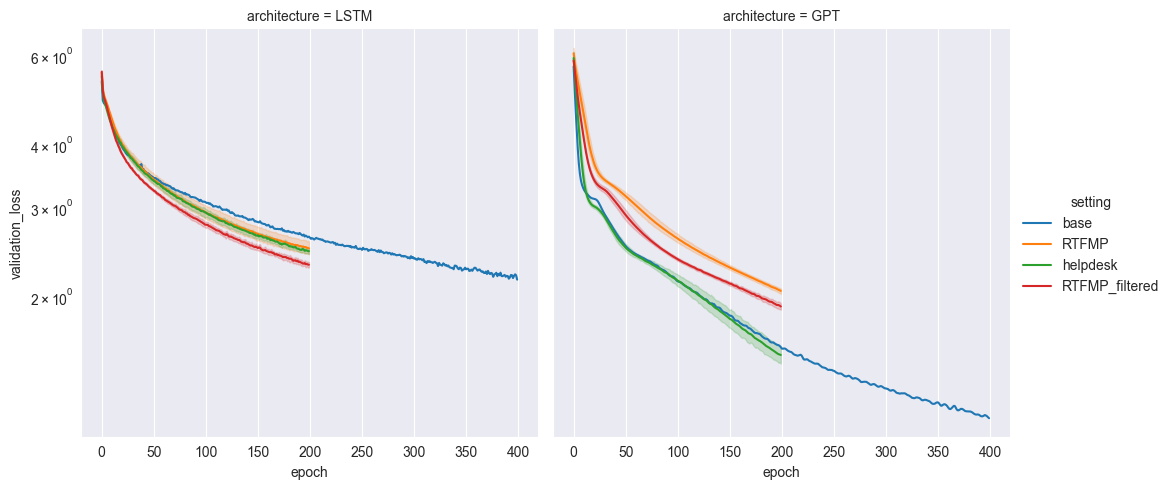

In [155]:
# Plot the validation loss based on the setting and the architecture
g = sns.relplot(
    data=all_training_results[all_training_results['log'] == 'BPI15'], 
    x='epoch', 
    y='validation_loss', 
    hue='setting',
    col='architecture',
    kind='line',
)
# Set the y axis to log scale
g.set(yscale='log')
# Save the figure as pdf and svg
g.savefig(f'{FIGURES_DIR}/validation_loss_bpi15.pdf')
g.savefig(f'{FIGURES_DIR}/validation_loss_bpi15.svg')

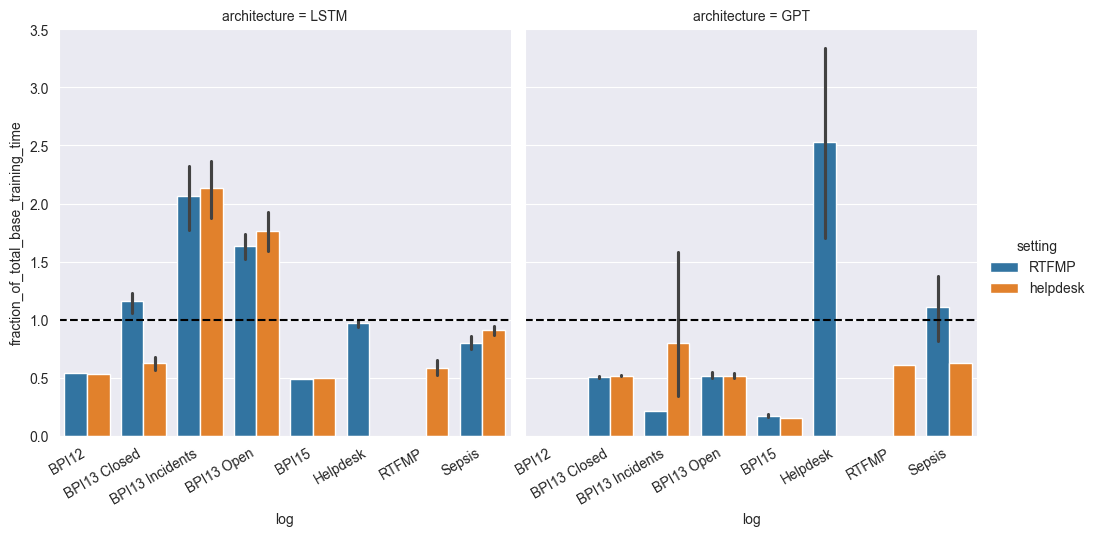

In [156]:
# Plot the fraction of the training time based on the base model
g = sns.catplot(
    data=training_results_df[training_results_df['setting'].isin(['RTFMP', 'helpdesk'])],
    x='log', 
    y='fraction_of_total_base_training_time', 
    hue='setting', 
    kind='bar', 
    col='architecture', 
    col_wrap=2)
# Draw a line at 1 to indicate the base model
for ax in g.axes:
    ax.axhline(1, ls='--', color='black')
# Rotate the xticklabels
g.set_xticklabels(rotation=30, horizontalalignment='right')
# Save the figure as pdf and svg
g.savefig(f'{FIGURES_DIR}/fraction_of_total_base_training_time.pdf')
g.savefig(f'{FIGURES_DIR}/fraction_of_total_base_training_time.svg')

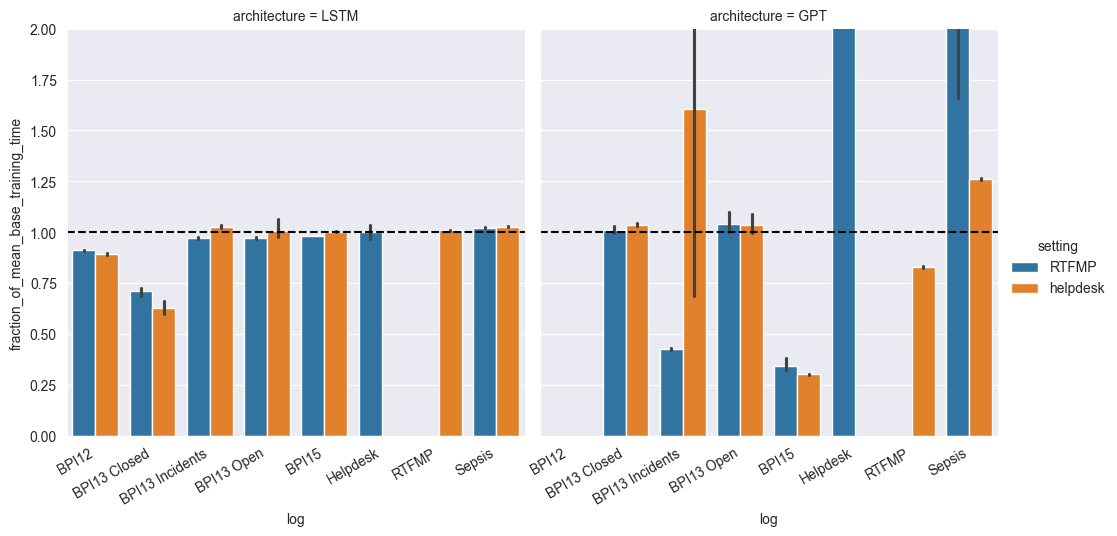

In [157]:
# Plot the fraction of the training time based on the base model
g = sns.catplot(
    data=training_results_df[training_results_df['setting'].isin(['RTFMP', 'helpdesk'])],
    x='log', 
    y='fraction_of_mean_base_training_time', 
    hue='setting', 
    kind='bar', 
    col='architecture', 
    col_wrap=2)
# Draw a line at 1 to indicate the base model
for ax in g.axes:
    ax.axhline(1, ls='--', color='black')
# Rotate the xticklabels
g.set_xticklabels(rotation=30, horizontalalignment='right')
# Set y min to 0.5
g.set(ylim=(0, 2))
# Save the figure as pdf and svg
g.savefig(f'{FIGURES_DIR}/fraction_of_mean_base_training_time.pdf')
g.savefig(f'{FIGURES_DIR}/fraction_of_mean_base_training_time.svg')

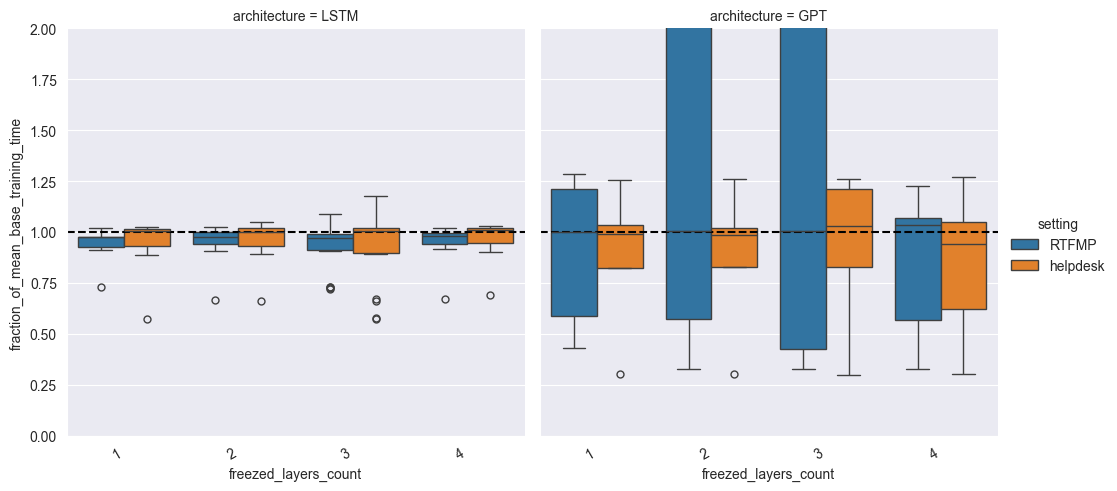

In [170]:
# Plot the fraction of the mean training time based on the count of freezed layers
g = sns.catplot(
    data=training_results_df[training_results_df['setting'].isin(['RTFMP', 'helpdesk'])],
    x='freezed_layers_count', 
    y='fraction_of_mean_base_training_time', 
    hue='setting', 
    kind='box', 
    # split=True,
    col='architecture', 
    col_wrap=2)
# Draw a line at 1 to indicate the base model
for ax in g.axes:
    ax.axhline(1, ls='--', color='black')
# Rotate the xticklabels
g.set_xticklabels(rotation=30, horizontalalignment='right')
# Set y min to 0.5
g.set(ylim=(0, 2))
# Save the figure as pdf and svg
g.savefig(f'{FIGURES_DIR}/fraction_of_mean_base_training_time_freezed_layers.pdf')
g.savefig(f'{FIGURES_DIR}/fraction_of_mean_base_training_time_freezed_layers.svg')

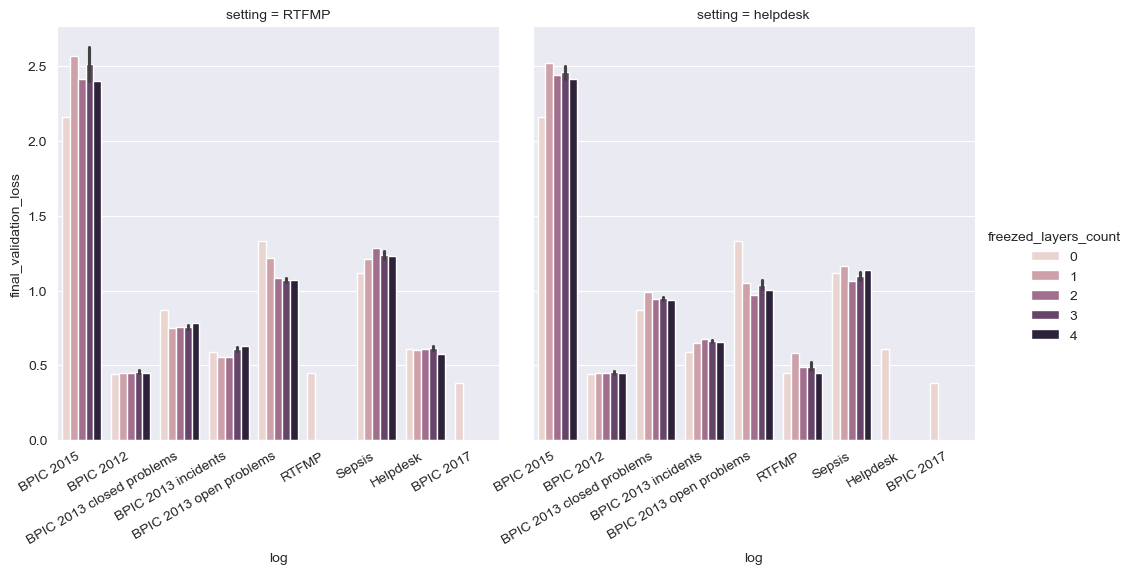

In [26]:
# Plot the fraction of the mean training time based on the count of freezed layers
# copy the dataframe and add a column with the log name without the count of freezed layers
data = training_results_df.copy()
# duplicate the base rows for each pre trained model
dfs = []
for pre_trained_setting in ['RTFMP', 'helpdesk']:
    base_rows = data[data['setting'] == 'base'].copy()
    base_rows['setting'] = pre_trained_setting
    base_rows['freezed_layers_count'] = 0
    dfs.append(base_rows)
data = pd.concat([data] + dfs)

g = sns.catplot(data=data[(data['setting'] != 'base') & (data['architecture'] == 'rnn')], x='log', y='final_validation_loss', hue='freezed_layers_count', kind='bar', col='setting', col_wrap=2)
# Rotate the xticklabels
g.set_xticklabels(rotation=30, horizontalalignment='right')

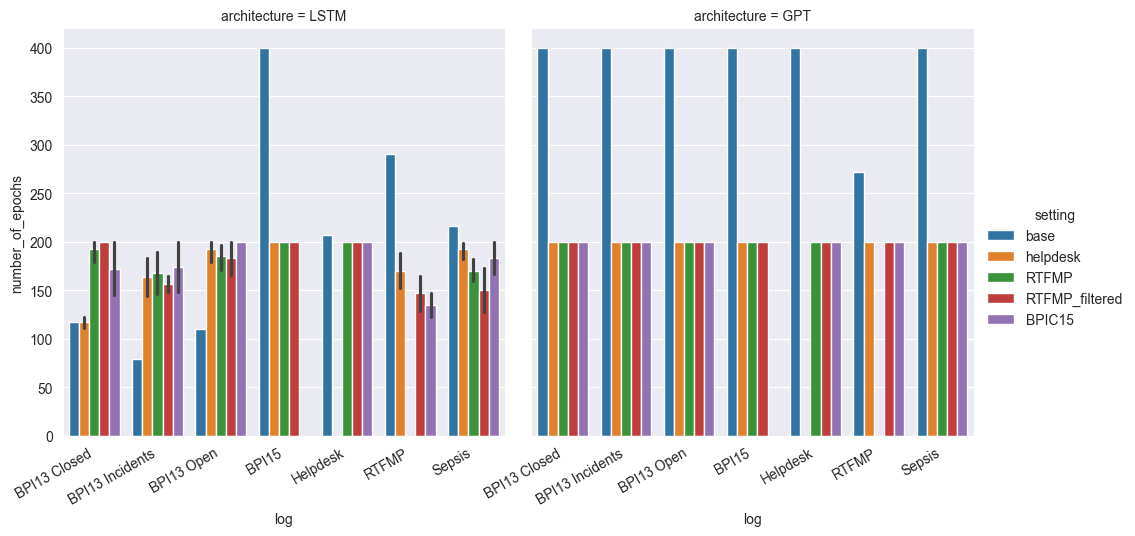

In [121]:
# Plot the difference in the total epochs needed for training based on the base model
logs_to_filter_out = ['BPI17', 'BPI12', 'RTFMP filtered']
g = sns.catplot(
    data=training_results_df[~training_results_df['log'].isin(logs_to_filter_out)],
    x='log', 
    y='number_of_epochs', 
    hue='setting', 
    hue_order=setting_order,
    kind='bar', 
    col='architecture', 
    col_order=architecture_order,
    col_wrap=2)
g.set_xticklabels(rotation=30, horizontalalignment='right')
# Save the figure as pdf and svg
g.savefig(f'{FIGURES_DIR}/number_of_epochs.pdf')
g.savefig(f'{FIGURES_DIR}/number_of_epochs.svg')

# Evaluation

In [47]:
all_evaluation_results = pd.read_csv(f'{RESULTS_DIR}/all_evaluation_results.csv')
all_evaluation_results['log'] = all_evaluation_results['log'].map(mapping)
all_evaluation_results['architecture'] = all_evaluation_results['architecture'].map(architecture_mapping)
all_evaluation_results['freezed_layers'] = all_evaluation_results['freezed_layers'].map(freezed_layers_mapping)
all_evaluation_results

,architecture,log,setting,freezed_layers,dls,mae,mae_denormalised,nb_worst_situs
0,LSTM,BPI17,base,None,0.0691,0.7416,100.9505,223449
1,LSTM,BPI17,RTFMP,"0, 1, 2, 3",0.0372,5.1177,696.6516,227572
2,LSTM,BPI15,base,None,0.0264,2.6185,2549.0971,9359
3,LSTM,BPI15,helpdesk,"0, 1, 2, 3",0.0226,2.4174,2353.3574,9307
4,LSTM,BPI15,helpdesk,"0, 1, 2",0.0323,1.8449,1795.9604,9226
...,...,...,...,...,...,...,...,...
249,GPT,Sepsis,RTFMP,"0, 1",0.0307,3.0372,1267.3097,2817
250,GPT,Sepsis,RTFMP,0,0.0307,1.5063,628.5306,2817
251,GPT,Sepsis,RTFMP_filtered,"0, 1, 2",0.0722,3.8692,1614.4840,2901
252,GPT,Sepsis,RTFMP_filtered,0,0.1253,0.1785,74.4924,2686


In [50]:
# We need to clean up the evaluation results a bit as there are some settings which have not been trained correctly
# We only keep the results that have a corresponding training result row based on the log, architecture, setting and freezed layers
evaluation_results_df = all_evaluation_results.merge(training_results_df, on=['log', 'architecture', 'setting', 'freezed_layers'], how='inner')
# Print the rows that have been removed based on the multi index
all_evaluation_results[~all_evaluation_results.set_index(['log', 'architecture', 'setting', 'freezed_layers']).index.isin(evaluation_results_df.set_index(['log', 'architecture', 'setting', 'freezed_layers']).index)]

,architecture,log,setting,freezed_layers,dls,mae,mae_denormalised,nb_worst_situs
1,LSTM,BPI17,RTFMP,"0, 1, 2, 3",0.0372,5.1177,696.6516,227572
153,GPT,BPI12,helpdesk,"0, 1, 2, 3",0.1525,0.6150,63.2542,43542
154,GPT,BPI12,RTFMP,"0, 1, 2, 3",0.0450,2.4248,249.3876,49597
181,GPT,BPI13 Incidents,helpdesk,"0, 1, 3",0.0637,1.2103,874.1276,8496


In [54]:
paper_results = pd.read_csv(f'{RESULTS_DIR}/paper_results.csv')
# Convert dls and mae to float and fill the - with NaN
paper_results['dls'] = paper_results['dls'].replace('-', float('nan')).astype(float)
paper_results['mae'] = paper_results['mae'].replace('-', float('nan')).astype(float)
# Rename the model column to architecture
paper_results = paper_results.rename(columns={'model': 'architecture'})
# Reformat the freezed layers
paper_results['freezed_layers'] = paper_results['freezed_layers'].map(lambda x: ', '.join(x.strip("[]").split(',')) if isinstance(x, str) else 'None')
paper_results

,log,architecture,setting,dls,mae,freezed_layers
0,BPI12,GPT,base,0.1606,77.19,None
1,BPI12,GPT,helpdesk,0.1586,67.15,"0, 1, 2, 3"
2,BPI12,GPT,RTFMP,0.1509,54.83,"0, 1"
3,BPI12,LSTM,base,0.0622,101.78,None
4,BPI12,LSTM,helpdesk,0.1377,38.92,"0, 1, 2, 3"
5,BPI12,LSTM,RTFMP,0.1188,68.44,"0, 1"
6,BPI13 Closed,GPT,base,0.4712,585.01,None
7,BPI13 Closed,GPT,helpdesk,0.6850,111.47,"0, 1, 3"
8,BPI13 Closed,GPT,RTFMP,0.7289,97.29,0
9,BPI13 Closed,LSTM,base,0.5014,154.69,None


In [56]:
# Create a dataframe with only the pre-trained models and the settings from the paper
reproducing_settings = ['RTFMP', 'helpdesk', 'base']

reproduced_results_df = evaluation_results_df[
    (evaluation_results_df['setting'].isin(reproducing_settings)) &     # only the settings from the paper
    (evaluation_results_df['log'] != 'RTFMP filtered')]                 # remove the RTFMP filtered log as it is not in the paper

In [133]:
def plot_reproduced(var, paper_var):
    g = sns.catplot(
        data=reproduced_results_df,
        x='log',
        y=var,
        hue='setting',
        col='architecture',
        kind='strip',
        dodge=True,
        jitter=True,
    )
    # Rotate the xticklabels
    g.set_xticklabels(rotation=30, horizontalalignment='right')
    # Show the conditional means
    sns.pointplot(
        data=reproduced_results_df[reproduced_results_df['architecture'] == 'LSTM'],
        x='log',
        y=var,
        hue='setting',
        dodge=.5,
        markers='_',
        ax=g.axes[0][0],
        legend=False,
        linestyles='', errorbar=None
    )
    sns.pointplot(
        data=reproduced_results_df[reproduced_results_df['architecture'] == 'GPT'],
        x='log',
        y=var,
        hue='setting',
        dodge=.5,
        markers='_',
        ax=g.axes[0][1],
        legend=False,
        linestyles='', errorbar=None
    )
    # Add the paper results
    sns.pointplot(
        data=paper_results[paper_results['architecture'] == 'LSTM'],
        x='log',
        y=paper_var,
        hue='setting',
        dodge=.5,
        markers='x',
        ax=g.axes[0][0],
        legend=False,
        linestyles='', errorbar=None
    )
    sns.pointplot(
        data=paper_results[paper_results['architecture'] == 'GPT'],
        x='log',
        y=paper_var,
        hue='setting',
        dodge=.5,
        markers='x',
        ax=g.axes[0][1],
        legend=False,
        linestyles='', errorbar=None
    )
    return g

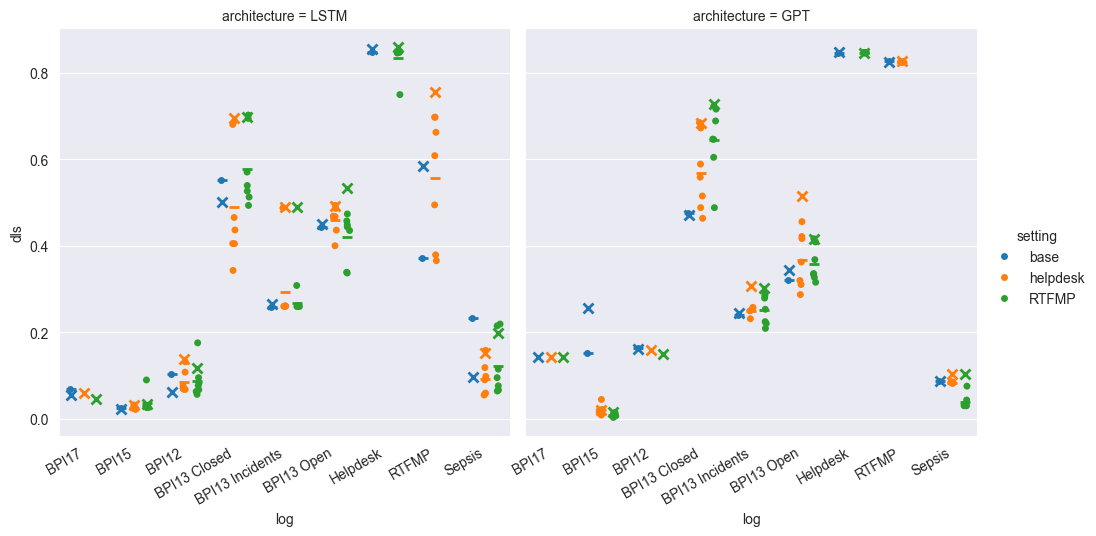

In [134]:
# Plot the dls score for the different logs and architectures for the pre-trained models
g = plot_reproduced('dls', 'dls')
# Save the figure as pdf and svg
g.savefig(f'{FIGURES_DIR}/reproduced_dls.pdf')
g.savefig(f'{FIGURES_DIR}/reproduced_dls.svg')

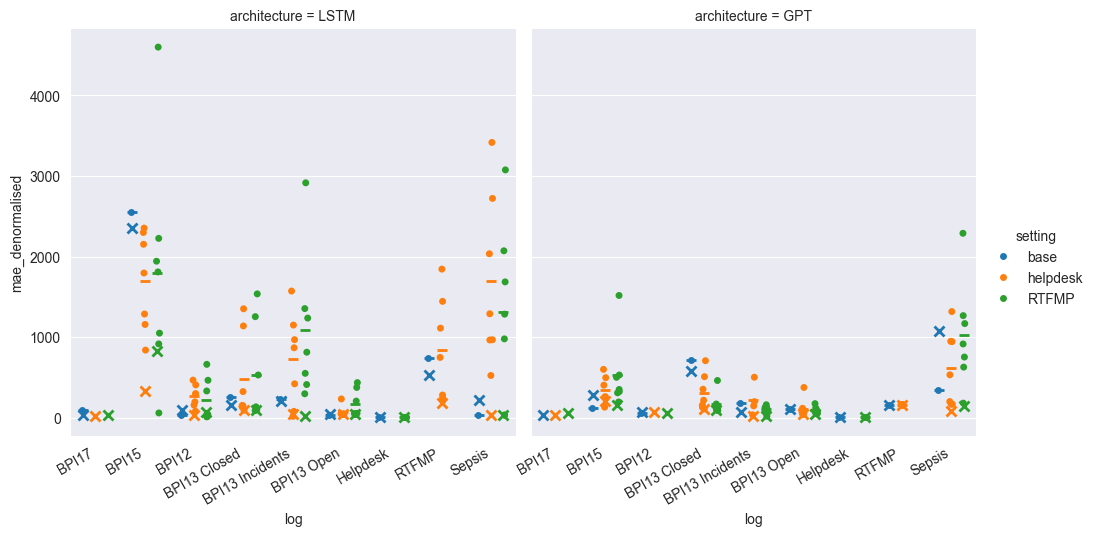

In [135]:
# Plot the mae score for the different logs and architectures for the pre-trained models
g = plot_reproduced('mae_denormalised', 'mae')
# Save the figure as pdf and svg
g.savefig(f'{FIGURES_DIR}/reproduced_mae.pdf')
g.savefig(f'{FIGURES_DIR}/reproduced_mae.svg')

In [146]:
data = reproduced_results_df[reproduced_results_df['setting'] != 'base'].copy()
def plot_layer_freezing(architecture):
    #Plot the dls score in order to find the best layer to freeze
    g = sns.catplot(
        data=data[data['architecture'] == architecture],
        x='log',
        y='dls',
        hue='freezed_layers',
        hue_order=freezed_layers_order,
        col='setting',
        kind='strip',
        dodge=True,
        jitter=False,
    )
    # Rotate the xticklabels
    g.set_xticklabels(rotation=30, horizontalalignment='right')
    # Add the paper results
    sns.pointplot(
        data=paper_results[(paper_results['architecture'] == architecture) & (paper_results['setting'] == 'helpdesk')],
        x='log',
        y='dls',
        hue='freezed_layers',
        hue_order=freezed_layers_order,
        markers='x',
        dodge=.75,
        ax=g.axes[0][0],
        legend=False,
        linestyles='', errorbar=None
    )
    sns.pointplot(
        data=paper_results[(paper_results['architecture'] == architecture) & (paper_results['setting'] == 'RTFMP')],
        x='log',
        y='dls',
        hue='freezed_layers',
        hue_order=freezed_layers_order,
        markers='x',
        dodge=.75,
        ax=g.axes[0][1],
        legend=False,
        linestyles='', errorbar=None
    )
    return g

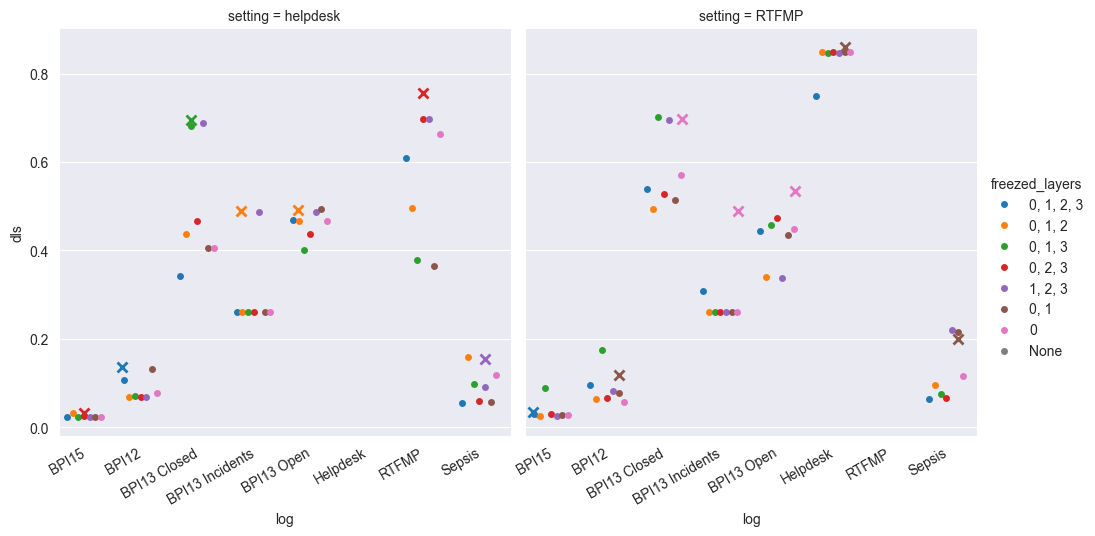

In [147]:
g = plot_layer_freezing('LSTM')
# Save the figure as pdf and svg
g.savefig(f'{FIGURES_DIR}/reproduced_dls_freezed_layers_lstm.pdf')
g.savefig(f'{FIGURES_DIR}/reproduced_dls_freezed_layers_lstm.svg')

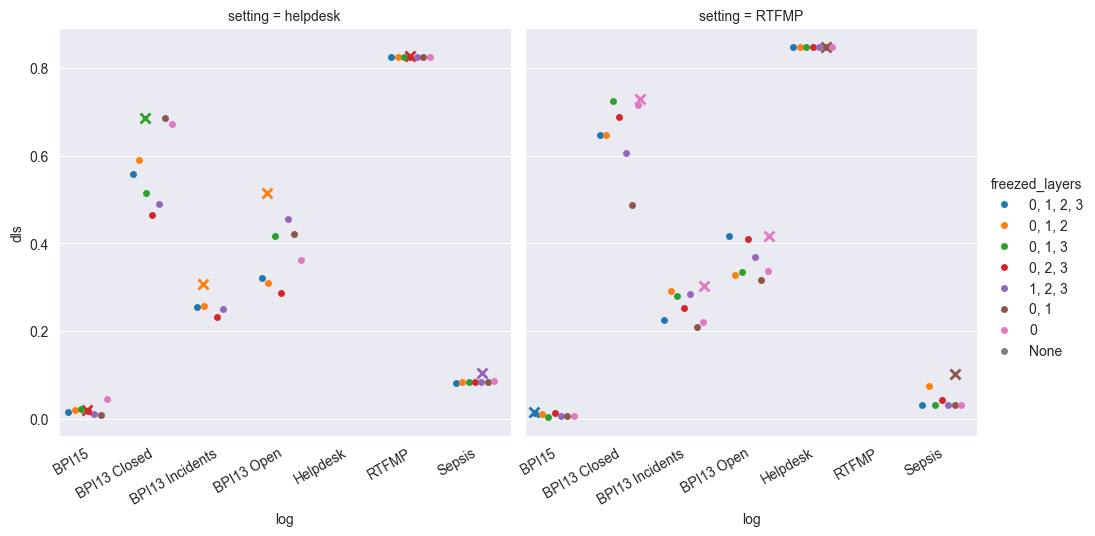

In [148]:
g = plot_layer_freezing('GPT')
# Save the figure as pdf and svg
g.savefig(f'{FIGURES_DIR}/reproduced_dls_freezed_layers_gpt.pdf')
g.savefig(f'{FIGURES_DIR}/reproduced_dls_freezed_layers_gpt.svg')

In [65]:
# We filter out the logs for which we have not trained a model
pre_trained_results_df = evaluation_results_df[(evaluation_results_df['log'] != 'BPI17') & (evaluation_results_df['log'] != 'BPI12') & (evaluation_results_df['log'] != 'RTFMP filtered')].copy()

In [87]:
# Plot the dls score for the different logs and architectures for the pre-trained models
def plot_pretrained(y):
    hue_order = ['base', 'helpdesk', 'RTFMP', 'RTFMP_filtered', 'BPIC15']
    # Plot the results for the first layer freeze (0, 1, 2)
    g = sns.catplot(
        data=pre_trained_results_df[pre_trained_results_df['freezed_layers'] == freezed_layers_order_additional[0]],
        x='log',
        y=y,
        hue='setting',
        hue_order=hue_order,
        col='architecture',
        kind='strip',
        dodge=True,
        jitter=True,
    )
    # Rotate the xticklabels
    g.set_xticklabels(rotation=30, horizontalalignment='right')
    # Add the other layer freeze result (0) with other markers
    sns.stripplot(
        data=pre_trained_results_df[(pre_trained_results_df['architecture'] == 'LSTM') & (pre_trained_results_df['freezed_layers'] == freezed_layers_order_additional[1])],
        x='log',
        y=y,
        hue='setting',
        hue_order=hue_order,
        dodge=True,
        jitter=True,
        marker='X',
        ax=g.axes[0][0],
        legend=False,
    )
    sns.stripplot(
        data=pre_trained_results_df[(pre_trained_results_df['architecture'] == 'GPT') & (pre_trained_results_df['freezed_layers'] == freezed_layers_order_additional[1])],
        x='log',
        y=y,
        hue='setting',
        hue_order=hue_order,
        dodge=True,
        jitter=True,
        marker='X',
        ax=g.axes[0][1],
        legend=False,
    )
    # Add the other layer freeze options with smaller markers
    sns.stripplot(
        data=pre_trained_results_df[pre_trained_results_df['architecture'] == 'LSTM'],
        x='log',
        y=y,
        hue='setting',
        hue_order=hue_order,
        dodge=True,
        jitter=True,
        marker='.',
        ax=g.axes[0][0],
        legend=False,
    )
    sns.stripplot(
        data=pre_trained_results_df[pre_trained_results_df['architecture'] == 'GPT'],
        x='log',
        y=y,
        hue='setting',
        hue_order=hue_order,
        dodge=True,
        jitter=True,
        marker='.',
        ax=g.axes[0][1],
        legend=False,
    )
    return g

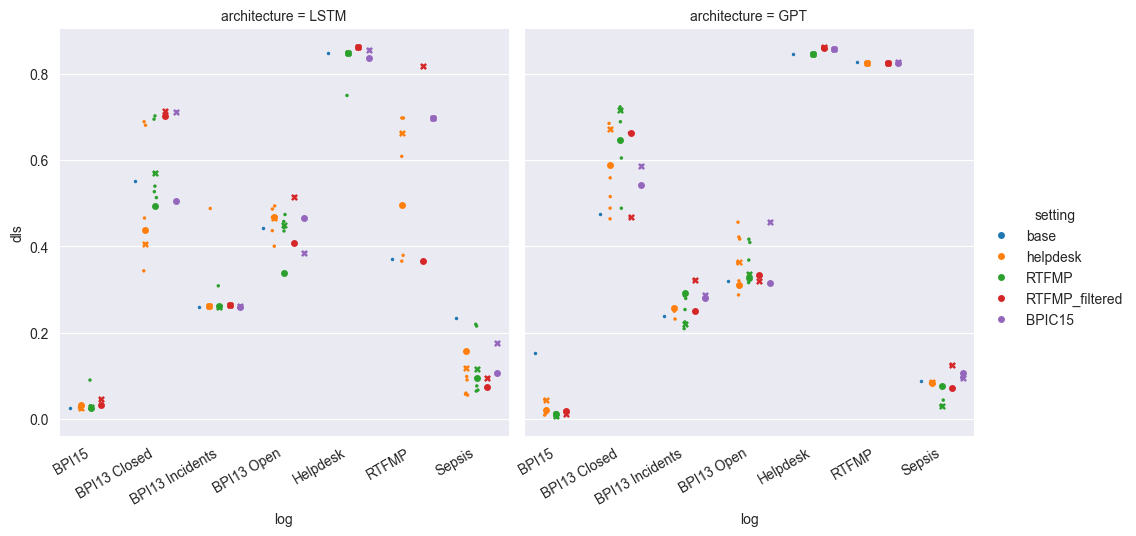

In [88]:
# Plot the dls score for the different logs and architectures for the pre-trained models
g = plot_pretrained('dls')
# Save the figure as pdf and svg
g.savefig(f'{FIGURES_DIR}/additional_dls.pdf')
g.savefig(f'{FIGURES_DIR}/additional_dls.svg')

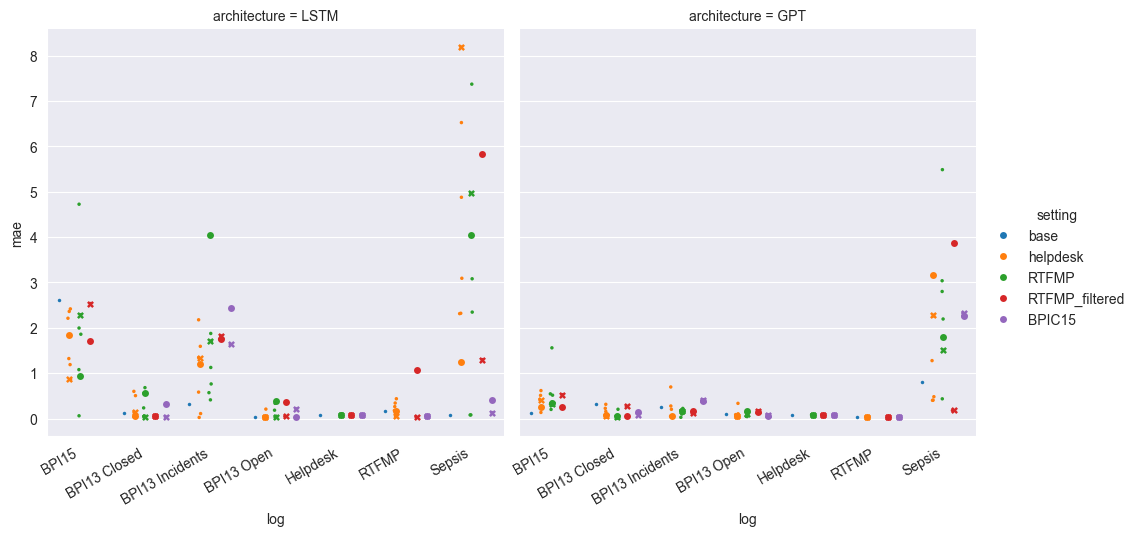

In [91]:
# Plot the mae score for the different logs and architectures for the pre-trained models
g = plot_pretrained('mae')
# Set the y axis to log scale
# g.set(yscale='log')
# Save the figure as pdf and svg
g.savefig(f'{FIGURES_DIR}/additional_mae.pdf')
g.savefig(f'{FIGURES_DIR}/additional_mae.svg')